# Анализ данных дейтингового приложения

Представьте, что вы работаете в крупном дейтинговом приложении.
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.
Проверьте:
1.	Был ли эксперимент успешен в целом.
2.	Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.


### Основной источник информации - это данные о пользователях (users*). Основная метрика, которая интересует бизнес в данном случае - выручка (total_revenue).

## Подключение библиотек и чтение данных

In [99]:
import requests 
from urllib.parse import urlencode

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats
# from scipy.stats import chisquare
from scipy import stats
from scipy.stats import levene

In [100]:
# функция чтения данных из csv-файла по имеющейся ссылке на яндекс-диск
def import_data(public_key, date_columns=None):
    # public_key - ссылка на файл на яндекс-диске
    # date_columns - столбцы датасета, содержащие даты. Их нужно распознать как даты
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    # формируем датафрейм
    df = pd.read_csv(download_url, sep=';', parse_dates=date_columns)
    return df


# чтение данных из 6 файлов
# информация о пользователях в тестовой группе
users_test = import_data('https://disk.yandex.ru/d/4XXIME4osGrMRA')
# информация о пользователях в первой контрольной группе
users_control1 = import_data('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
# информация о пользователях во второй контрольной группе
users_control2 = import_data('https://disk.yandex.ru/d/br6KkQupzzTGoQ')

# информация о платежах пользователей в тестовой группе
transactions_test = import_data('https://disk.yandex.ru/d/gvCWpZ55ODzs2g', ['joined_at', 'paid_at'])
# информация о платежах пользователей в первой контрольной группе
transactions_control1 = import_data('https://disk.yandex.ru/d/VY5W0keMX5TZBQ', ['joined_at', 'paid_at'])
# информация о платежах пользователей во второй контрольной группе
transactions_control2 = import_data('https://disk.yandex.ru/d/th5GL0mGOc-qzg', ['joined_at', 'paid_at'])

## Исследование данных

### информация о пользователях в тестовой и 2х контрольных группах

Разместим рядом или в одних осях однотипные таблицы и графики, попытаемся "на глаз" определить различия между группами

In [101]:
# структура датасета users_test
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


users_*.csv – информация о пользователях:

    uid – идентификатор пользователя
    age – возраст
    attraction_coeff – коэффициент привлекательности (от 0 до 1000, {лайки}/{просмотры}*1000)
    coins – число монеток (внутренняя валюта)
    country – страна  
    visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
    gender – пол
    age_filter_start  – фильтр поиска, мин. значение 
    age_filter_end  – фильтр поиска, макс. значение 
    views_count – число полученных оценок 
    was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
    is_premium –  является ли премиум
    total_revenue – нормированная выручка

In [102]:
users_test.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


In [103]:
users_control1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,60.0000,4340.000000,4340.000000,4340.000000,4340.000000,436.0,192.0,4340.000000
mean,8.917578e+08,32.095392,312.048848,1745.9000,0.958065,26.793779,38.553226,44.467512,1.0,1.0,594.761982
std,1.125683e+06,10.257466,320.972130,12902.3577,0.200465,9.405103,15.226951,204.800272,0.0,0.0,7987.922925
min,8.910510e+08,16.000000,0.000000,1.0000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913626e+08,24.000000,0.000000,8.0000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917272e+08,30.000000,238.500000,11.5000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920898e+08,38.000000,518.000000,28.0000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.0000,1.000000,96.000000,102.000000,4953.000000,1.0,1.0,486330.000000


In [104]:
users_control2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,61.000000,4264.000000,4264.000000,4264.000000,4264.000000,411.0,191.0,4264.000000
mean,8.917694e+08,32.046201,317.957317,18.147541,0.954268,26.954268,38.906895,45.064493,1.0,1.0,450.384146
std,2.520759e+06,10.170721,326.191737,35.439543,0.208927,9.546657,15.955574,318.188992,0.0,0.0,2859.242228
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913453e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917205e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920735e+08,38.000000,548.500000,20.000000,1.000000,32.000000,45.000000,20.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.0,1.0,81796.000000


Распределение переменной gender (пол пользователя) примерно одинаково в тестовой и контрольных группах, у переменной total_revenue большой размах, максимальный возраст пользователя представляется сомнительным.

In [105]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [106]:
users_control1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [107]:
users_control2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

Для 

In [108]:
transactions_test.describe()

,uid,revenue,payment_id
count,2.730000e+02,273.000000,273.000000
mean,8.918375e+08,8589.380952,98.227106
std,3.777452e+05,11127.479971,57.762760
min,8.910712e+08,533.000000,0.000000
25%,8.915082e+08,2743.000000,19.000000
50%,8.919143e+08,6305.000000,146.000000
75%,8.921442e+08,12597.000000,147.000000
max,8.924386e+08,113477.000000,147.000000


In [109]:
transactions_control1.describe()

,uid,revenue,payment_id
count,3.770000e+02,377.000000,377.000000
mean,8.923612e+08,6929.206897,91.145889
std,6.162900e+06,8027.889630,58.599773
min,8.910923e+08,26.000000,0.000000
25%,8.913833e+08,2730.000000,19.000000
50%,8.918225e+08,6266.000000,127.000000
75%,8.921850e+08,6448.000000,147.000000
max,9.609370e+08,63037.000000,147.000000


In [110]:
transactions_control2.describe()

,uid,revenue,payment_id
count,3.280000e+02,328.000000,328.000000
mean,8.918121e+08,5854.993902,95.527439
std,3.802149e+05,6582.242539,57.247832
min,8.910681e+08,481.000000,0.000000
25%,8.915738e+08,2323.750000,19.000000
50%,8.918626e+08,4706.000000,146.000000
75%,8.921281e+08,6314.750000,147.000000
max,8.924388e+08,81796.000000,147.000000


In [111]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [112]:
transactions_control1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [113]:
transactions_control2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [114]:
# в данных о транзакциях пользователей 1й контрольной группы много пропущенных значений
transactions_control1.tail()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1006,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [115]:
# Из датафрейма transactions_control1 удалим пустые значения. Очевидно, при выгрузке данных что-то засбоило.
transactions_control1 = transactions_control1.dropna()
transactions_control1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

Вывод: датафреймы (после некоторой доработки), по крайней мере, однотипны. 

Объединим датафреймы для удобства обработки и рассмотрим распределение переменных

In [116]:
users_test['group'] = 'test'
users_control1['group'] = 'control1'
users_control2['group'] = 'control2'
users = pd.concat([users_test, users_control1, users_control2])
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test


In [117]:
transactions_test['group'] = 'test'
transactions_control1['group'] = 'control1'
transactions_control2['group'] = 'control2'
transactions = pd.concat([transactions_test, transactions_control1, transactions_control2])
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [118]:
users.shape

(12912, 14)

In [119]:
users.nunique()

uid                 12912
age                    69
attraction_coeff      847
coins                  50
country                72
visit_days           2132
gender                  2
age_filter_start       67
age_filter_end         81
views_count           564
was_premium             1
is_premium              1
total_revenue         293
group                   3
dtype: int64

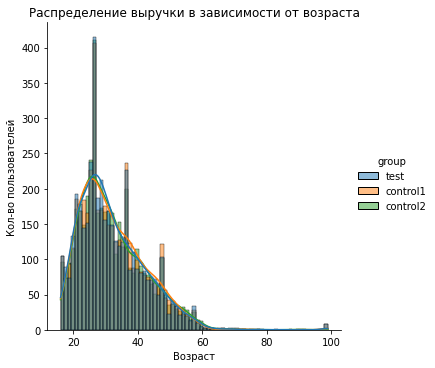

In [120]:
# распределение переменной age (возраст пользователей) в 3х группах
sns.displot(data=users, x='age', kde=True, kind='hist', hue='group')
plt.title('Распределение выручки в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Кол-во пользователей');

Распределения по возрасту отличаются в разных группах, но нельзя сказать наверняка, что группы различаются

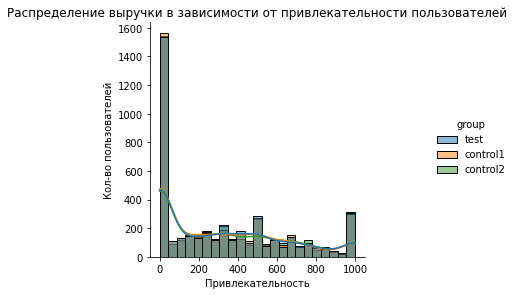

In [121]:
# распределение переменной attraction_coeff (привлекательность) в 3х группах
sns.displot(data=users, x='attraction_coeff', kind='hist', kde=True, hue='group', height=4)
plt.title('Распределение выручки в зависимости от привлекательности пользователей')
plt.xlabel('Привлекательность')
plt.ylabel('Кол-во пользователей');

Распределение привлекательности пользователей в 3х группах схоже

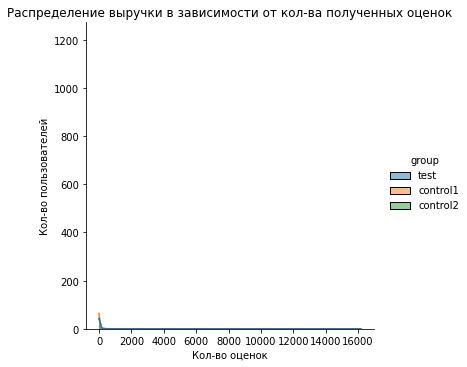

In [122]:
# распределение переменной views_count (кол-во полученных оценок) в 3х группах
sns.displot(data=users, x='views_count', kind='hist', kde=True, hue='group')
plt.title('Распределение выручки в зависимости от кол-ва полученных оценок')
plt.xlabel('Кол-во оценок')
plt.ylabel('Кол-во пользователей');

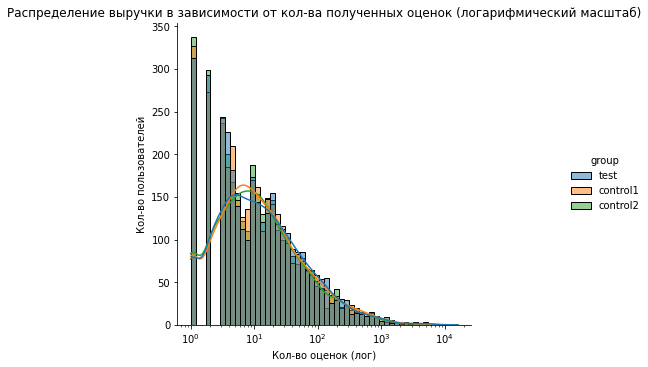

In [123]:
# рассмотрим переменную views_count в логарифмическом масштабе (исключив предварительно нулевые значения)
sns.displot(data=users.query('views_count > 0'), x='views_count', 
            kind='hist', kde=True, hue='group', log_scale=True)
plt.title('Распределение выручки в зависимости от кол-ва полученных оценок (логарифмический масштаб)')
plt.xlabel('Кол-во оценок (лог)')
plt.ylabel('Кол-во пользователей');

Переменная "кол-во просмотров" распределена крайне неравномерно. У основного количества пользователей нулевое или минимальное количество просмотров, но у некоторых оно очень велико. Рассмотрим пользователей с кол-вом просмотров более 5000

In [124]:
users.query('views_count > 5000').shape

(5, 14)

In [125]:
users.query('views_count > 5000')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
263,892237956,27,3,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",0,24,30,7110,NaN,NaN,0,test
2937,905158620,16,579,8466.0,Russian Federation,"1,2,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,26,...",0,26,33,12831,1.0,1.0,0,test
3310,891984801,31,302,NaN,Russian Federation,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",0,28,34,5390,NaN,NaN,0,test
225,892032072,26,0,NaN,United Kingdom (Great Britain),"1,2,3",0,16,99,16157,1.0,NaN,3588,control2
1231,891380856,23,652,NaN,Turkey,"1,2,3",0,20,26,6139,NaN,NaN,0,control2


С одной стороны, рассмотренные пользователи не типичны. Тем не менее, они могут быть важны для анализа, а на технические сбои при сборе статистики это не похоже. Эти пользователи останутся в выборке.

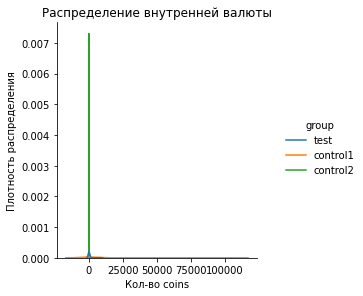

In [126]:
# рассмотрим распределение переменной coins (локальная "валюта")
sns.displot(data=users, x='coins', kind='kde', hue='group', height=4)
plt.title('Распределение внутренней валюты')
plt.xlabel('Кол-во coins')
plt.ylabel('Плотность распределения');

Пик в точке 0 (у большинства пользователей нет "валюты" на счете), что не позволяет рассмотреть ненулевые значения. При этом, предположительно, "валюта" может быть куплена за реальные деньги, т.е. приносить прибыль компании, и это стоит обязательно проверить в дальнейшем. Рассмотрим распределение в логарифмическом масштабе, удалив нулевые значения.
Здесь и далее на графиках распределений переменных присутствуют отрицательные значения по оси абсцисс. Как мы убедились выше (см. вывод команды "describe"), это чисто технический эффект, то есть, на самом деле значения переменной coins и других неотрицательны.

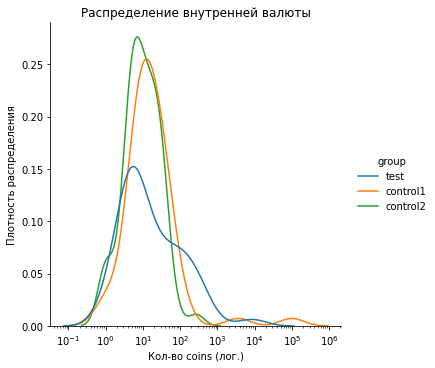

In [127]:
# рассмотрим переменную views_count в логарифмическом масштабе (исключив предварительно нулевые значения)
sns.displot(data=users.query('coins > 0'), x='coins', kind='kde', hue='group', log_scale=True)
plt.title('Распределение внутренней валюты')
plt.xlabel('Кол-во coins (лог.)')
plt.ylabel('Плотность распределения');

In [128]:
# рассмотрим "топовых" пользователей по кол-ву coins
users.query('coins > 1000').head(4)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
2937,905158620,16,579,8466.0,Russian Federation,"1,2,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,26,...",0,26,33,12831,1.0,1.0,0,test
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,control1
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,control1


Распределения переменной coins в тестовой группе по форме схоже с распределением в контрольных, однако явно отличается количественно. 
Пользователи с coins > 5000 - явные выбросы (остальные пользователи в этой выборке более типовые), к тому же не принесли большой прибыли. Не имеет смысла оставить их в выборке для анализа.

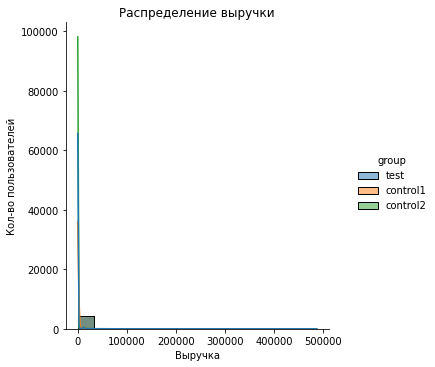

In [129]:
# рассмотрим распределение переменной total_revenue (выручка с пользователя)
sns.displot(data=users, x='total_revenue', kind='hist', kde=True, hue='group')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Кол-во пользователей');

Распределение имеет ярко выраженный пик в точке 0, т.е. большое количество пользователей ничего не платит в приложении. Но хотелось бы также взглянуть на ненулевую выручку, т.к. нас больше всего интересуют именно прибыль (ненулевая). Для этого рассмотрим переменную total_revenue в логарифмическом масштабе (исключив предварительно нулевые значения)

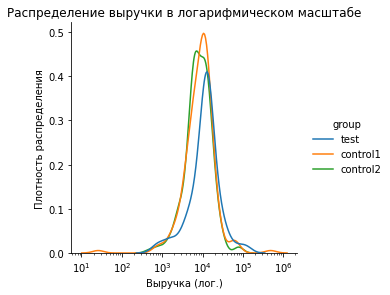

In [130]:
sns.displot(data=users.query('total_revenue > 0'), x='total_revenue', kind='kde', hue='group', log_scale=True, height=4)
plt.title('Распределение выручки в логарифмическом масштабе')
plt.xlabel('Выручка (лог.)')
plt.ylabel('Плотность распределения');

Переменная total_revenue, на первый взгляд, в тестовой группе распределена отлично от контрольных групп, а именно платящих пользователей стало меньше, но отдельные платежи выросли. Однако эффект, если он есть, не настолько очевиден, чтобы делать однозначные выводы - необходимо применить статистические инструменты.

## Дополнительные расчеты

Добавим переменные interval_width (ширина интервала поиска), visits (кол-во посещений), last_visit (день последнего визита пользователя со дня его регистрации - как мера длительности присутствия пользователя в сервисе),  рассмотрим их распределение.

In [131]:
users['interval_width'] = users.age_filter_end - users.age_filter_start
users['visits'] = users.visit_days.str.split(',', 0).apply(lambda x: 0 if x != x else len(x))
users['last_visit'] = users.visit_days.str.split(',', 0).apply(lambda x: np.NaN if x != x else int(x[len(x) - 1]))
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,interval_width,visits,last_visit
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test,6,14,17.0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test,6,0,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test,6,20,26.0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test,6,12,12.0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test,6,0,NaN


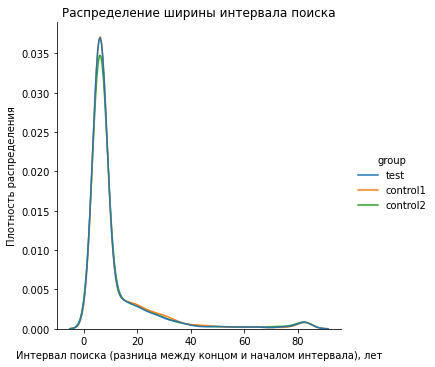

In [132]:
# распределение переменной interval_width (ширина интервала возраста поиска)
sns.displot(data=users, x='interval_width', kind='kde', hue='group')
plt.title('Распределение ширины интервала поиска')
plt.xlabel('Интервал поиска (разница между концом и началом интервала), лет')
plt.ylabel('Плотность распределения');

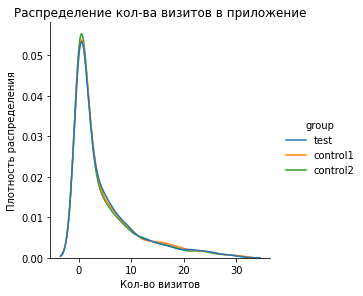

In [133]:
# распределение переменной visits (кол-во визитов пользователя в приложение)
sns.displot(data=users, x='visits', kind='kde', hue='group', height=4)
plt.title('Распределение кол-ва визитов в приложение')
plt.xlabel('Кол-во визитов')
plt.ylabel('Плотность распределения');

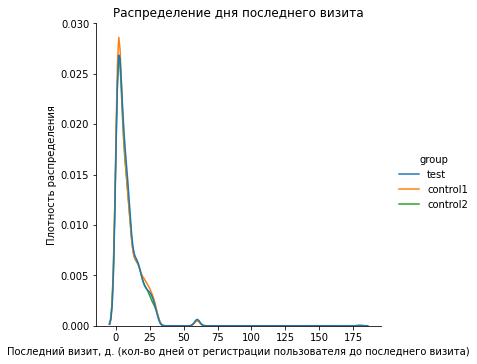

In [134]:
# распределение переменной last_visit (день последнего визита)
sns.displot(data=users, x='last_visit', kind='kde', hue='group')
plt.title('Распределение дня последнего визита')
plt.xlabel('Последний визит, д. (кол-во дней от регистрации пользователя до последнего визита)')
plt.ylabel('Плотность распределения');

Итак, распределение трех новых переменных схоже во всех группах

In [135]:
# заменим в столбцах is_premium, was_premium, coins nan на 0
users.is_premium = users.is_premium.fillna(0)
users.was_premium = users.was_premium.fillna(0)
users.coins = users.coins.fillna(0)

In [136]:
# распределение переменной was_premium 
users.groupby('group').agg({'was_premium': 'mean'})

,was_premium
group,
control1,0.100461
control2,0.096388
test,0.094708


In [137]:
# распределение переменной is_premium 
users.groupby('group').agg({'is_premium': 'mean'})

,is_premium
group,
control1,0.044240
control2,0.044794
test,0.036444


Кол-во премиальных пользователей снизилось в тестовой группе по сравнению с контрольными. Однако не очевидно, случайный ли это эффект, для выяснения этого необходимо применение статистических методов.

In [138]:
metrics = users.groupby('group').agg({'uid': 'count', 'total_revenue': 'sum'})

metrics = metrics.rename(columns={"uid": "num_users"})

metrics['num_paying_users'] = users[users.total_revenue > 0].groupby('group').agg({'uid': 'count'})
# среднее квадратическое отклонение для arppu
metrics['arppu_std'] = users[users.total_revenue > 0].groupby('group').agg({'total_revenue': 'std'})

# средняя выручка на пользователя
metrics['arpu'] = metrics.total_revenue / metrics.num_users
# средняя выручка на платящего пользователя
metrics['arppu'] = metrics.total_revenue / metrics.num_paying_users
# конверсия
metrics['conversion'] = metrics.num_paying_users / metrics.num_users

metrics

,num_users,total_revenue,num_paying_users,arppu_std,arpu,arppu,conversion
group,,,,,,,
control1,4340,2581267,192,35719.282523,594.761982,13444.098958,0.044240
control2,4264,1920438,187,9272.960475,450.384146,10269.721925,0.043856
test,4308,2300818,146,18058.118399,534.080316,15759.027397,0.033890


Доверительный интервал для разности пропорций: формула

Мы используем следующую формулу для расчета доверительного интервала для разницы между двумя пропорциями населения:

Доверительный интервал = (p 1 –p 2 ) +/- z*√(p 1 (1-p 1 )/n 1 + p 2 (1-p 2 )/n 2 )

К сожалению, на этом сервере готовые функции для расчета этих доверительных интервалов использовать не удалось (модули не импортировались)

In [139]:
cnv_left_ci = metrics.conversion['control1'] - metrics.conversion['test'] - 1.96 * \
              math.sqrt(metrics.conversion['control1'] * 
                        (1 - metrics.conversion['control1']) / metrics.num_users['control1'] + 
                         metrics.conversion['test'] * (1 - metrics.conversion['test']) / metrics.num_users['test'])
cnv_right_ci = metrics.conversion['control1'] - metrics.conversion['test'] + 1.96 * \
               math.sqrt(metrics.conversion['test'] * (1 - metrics.conversion['test']) / metrics.num_users['control1'] + 
               metrics.conversion['test'] * (1 - metrics.conversion['test']) / metrics.num_users['test'])

print('Доверительный интервал разницы конверсий (control1 - test): [', round(cnv_left_ci, 3), ', ', 
      round(cnv_right_ci, 3), '], разница конверсий: ', 
      round(metrics.conversion['control1'] - metrics.conversion['test'], 3))
print('Доверительный интервал разницы конверсий (control1 - test) в % от конверсии 1й контрольной группы: [', 
      round(cnv_left_ci / metrics.conversion['control1'] * 100, 2), ', ', 
      round(cnv_right_ci / metrics.conversion['control1'] * 100, 2), ']')

Доверительный интервал разницы конверсий (control1 - test): [ 0.002 ,  0.018 ], разница конверсий:  0.01
Доверительный интервал разницы конверсий (control1 - test) в % от конверсии 1й контрольной группы: [ 4.94 ,  40.63 ]


Доверительный интервал для разницы между средними: формула

Мы используем следующую формулу для расчета доверительного интервала для разницы между двумя средними значениями:

Доверительный интервал = ( x 1 – x 2 ) +/- t * √ ((s p 2 /n 1 ) + (s p 2 /n 2 ))

куда:

    x 1 , x 2 : среднее значение для образца 1, среднее значение для образца 2
    t: t-критическое значение, основанное на доверительном уровне и (n1 +n2 -2) степенях свободы
    s p 2 : объединенная дисперсия
    n 1 , n 2 : размер выборки 1, размер выборки 2

куда:

    Объединенная дисперсия рассчитывается как: s p 2 = ((n 1 -1)s 1 2 + (n 2 -1)s 2 2 ) / (n 1 +n 2 -2)
    Критическое значение t можно найти с помощью калькулятора обратного t-распределения.

In [140]:
arppu_total_std = (metrics.arppu_std['control1'] * (metrics.num_paying_users['control1'] - 1) + 
                   metrics.arppu_std['test'] * (metrics.num_paying_users['test'] - 1)) / \
                  (metrics.num_paying_users['control1'] + metrics.num_paying_users['test'])
arppu_difference = metrics.arppu['test'] - metrics.arppu['control1']
t_cr = scipy.stats.t.ppf(q=0.95, df=metrics.num_paying_users['control1'] + metrics.num_paying_users['test'] - 2)
arppu_left_ci = arppu_difference - t_cr * math.sqrt(arppu_total_std / metrics.num_paying_users['control1'] + 
                arppu_total_std / metrics.num_paying_users['test']) 
arppu_right_ci = arppu_difference + t_cr * math.sqrt(arppu_total_std / metrics.num_paying_users['control1'] + 
                 arppu_total_std / metrics.num_paying_users['test']) 
print('Доверительный интервал разницы arppu (control1 - test): [', round(arppu_left_ci, 2), ', ', 
      round(arppu_right_ci, 2), '], разница arppu: ', round(arppu_difference, 2))
print('Насколько повысился arppu в тестовой группе относительно 1й контрольной. Довер. интервал в %: [', 
      round(arppu_left_ci / metrics.arppu['control1'] * 100, 2), ', ', 
      round(arppu_right_ci / metrics.arppu['control1'] * 100, 2), ']')

Доверительный интервал разницы arppu (control1 - test): [ 2284.66 ,  2345.2 ], разница arppu:  2314.93
Насколько повысился arppu в тестовой группе относительно 1й контрольной. Довер. интервал в %: [ 16.99 ,  17.44 ]


Итак, средняя выручка на одного пользователя в тестовой группе "посередине" между соответствующими показателями контрольных групп, выручка на платящего пользователя в тестовой группе увеличивается по отношению к контрольным группам, а конверсия - снижается.

Рассмотрим "популярность" продуктов у пользователей

In [141]:
products = \
    transactions.groupby(['product_type', 'group'], as_index=False).agg({'revenue': 'sum', 'uid': 'count'})

products = products.merge(users.groupby('group').agg({'uid': 'count'}), on='group')
products = products.rename(columns={'uid_x': 'n_purchase', 'uid_y': 'n_users_in_group'})
products['arpu'] = products.revenue / products.n_users_in_group
products['buy_frequency'] = products.n_purchase / products.n_users_in_group
products = products.pivot(index='product_type', columns='group', values=['buy_frequency', 'arpu'])
products['fr_test_vs_control1'] = products.buy_frequency.test / products.buy_frequency.control1
products['fr_test_vs_control2'] = products.buy_frequency.test / products.buy_frequency.control2
products['arpu_test_vs_control1'] = products.arpu.test / products.arpu.control1
products['arpu_test_vs_control2'] = products.arpu.test / products.arpu.control2

products[['fr_test_vs_control1', 'fr_test_vs_control2', 'arpu_test_vs_control1', 'arpu_test_vs_control2']]

,fr_test_vs_control1,fr_test_vs_control2,arpu_test_vs_control1,arpu_test_vs_control2
group,,,,
product_type,,,,
coins,0.716694,0.846108,0.654175,1.390868
other_type,0.531189,0.652359,0.897260,1.290231
premium_no_trial,0.722307,0.703026,1.048083,1.077358
trial_premium,0.932247,1.157863,1.043257,1.229895


Предположительно:

1) По продукту trial_premium средняя выручка на пользователя в тестовой группе увеличилась, а частота покупок ("популярность") не изменилась.

2) по продукту trial_no_premium средняя выручка на пользователя в тестовой группе увеличилась, а частота покупок снизилась.

3) По остальным продуктам частота покупок в тестовой группе снизилась, а о средней выручке на пользователя ничего сказать нельзя. Таким образом, пользователи, покупающие coins и производящие платежи других типов (other_type), в контексте данного эксперимента нам менее интересны, чем покупающие premium. Это закономерно, так как суть эксперимента была именно в изменении стоимости премиум-подписки.

### Переменная country (страна) 

Самая важная информация - каких странах проводили эксперимент, однако в датасете ее нет. Это можно было бы выяснить в диалоге с бизнес-заказчиком (но такой возможности не было) либо проанализировав данные о транзакциях - но мы знаем, что стоимость изменилась лишь при использовании двух новых платежных систем (причем о платежных системах нет никакой информации), а не для всех пользователей.

In [142]:
# Рассмотрим распределение пользователей по странам. Возможно, часть стран стоит исключить из анализа
top_countries = pd.DataFrame(users.country.value_counts(normalize=True)).reset_index().\
    rename(columns={'country': 'rate', 'index': 'country'})
top_countries.head(20)

,country,rate
0,United States of America,0.341310
1,Argentina,0.091543
2,France,0.085579
3,Italy,0.073885
4,Spain,0.073807
5,Chile,0.065443
6,United Arab Emirates,0.049876
7,Germany,0.046391
8,United Kingdom (Great Britain),0.035703
9,Canada,0.031366


In [143]:
# Отмечаем страны, в которых не более 0.5% пользователей приложения, признаком "Other"
users['top_country'] = \
    users.country.apply(lambda x: x if x in top_countries.query('rate > 0.005').country.values else 'Other')

Проверим, схожи ли 3 группы пользователей в распределении по странам

In [144]:
countries_distr = pd.pivot(users.groupby(['top_country', 'group'], as_index=False).agg({'uid': 'count'}), 
                  index=['top_country'], columns=['group'], values='uid')
group_distr = users.groupby('group').agg({'uid': 'count'})
countries_distr['control1'] = countries_distr['control1'] / group_distr.uid['control1'] * 100
countries_distr['control2'] = countries_distr['control2'] / group_distr.uid['control2'] * 100
countries_distr['test'] = countries_distr['test'] / group_distr.uid['test'] * 100
# показатель "неоднородности" распределения пользователей по группам в рамках каждой страны (нужен для наглядности; 
# проверять, внутри стран есть преобладание той или иной группы, проверим статистически)
countries_distr['diff'] = round((countries_distr.max(axis=1) - countries_distr.min(axis=1)) / countries_distr.max(axis=1), 2)
countries_distr.sort_values('diff', ascending=False)

group,control1,control2,test,diff
top_country,,,,
Israel,2.511521,1.829268,2.460539,0.27
Other,1.359447,1.618199,1.857010,0.27
Australia,1.152074,1.196060,1.439183,0.20
Switzerland,0.967742,0.820826,0.812442,0.16
Belgium,2.488479,2.110694,2.135562,0.15
United Kingdom (Great Britain),3.364055,3.424015,3.922934,0.14
Italy,7.788018,6.871482,7.497679,0.12
Germany,4.331797,4.737336,4.851439,0.11
Spain,7.880184,7.270169,6.987001,0.11


Проверяется гипотеза Н0 о том, что распределения величин совпадают, с помощью критерия хи-квадрат на уровне значимости 0.05. Если p-value < 0.05, то гипотеза отклоняется (тогда распределения величин не совпадают).

In [145]:
chisquare(countries_distr.test, f_exp=[countries_distr.control2, countries_distr.control1], axis=1)

Power_divergenceResult(statistic=array([0.57987505, 0.68859717]), pvalue=array([0.99999999, 0.99999998]))

Так как p-value в обоих случаях превышает 0.05, то сделаем вывод, что распределение пользователей каждой из стран по трем группам происходило "правильно", т.е. отбор в группы был случаен по этому признаку (на выбранном уровне значимости).

### Работа с выбросами

In [146]:
users.coins.sort_values(ascending=False).head(5)

510     99958.0
2937     8466.0
1427     3608.0
597       530.0
406       378.0
Name: coins, dtype: float64

In [147]:
users.total_revenue.sort_values(ascending=False).head(5)

1427    486330
3629    129870
992     123565
406      95823
1360     81796
Name: total_revenue, dtype: int64

Удалим пользователей с максимальными значениями переменных coins и total_revenue, т. к. они могут помешать анализу (при проведении АВ-тестов стоит снижать дисперсию, при этом удаление нескольких пользователей из выборки не помешает анализу, так как большую часть прибыли компания получает не от них). Удалим также пользователей с возрастом, нехарактерным для пользователей сайтов знакомств (age >= 70).

In [148]:
transactions = transactions.merge(users[{'uid', 'coins', 'age', 'total_revenue'}], on='uid', how='left')
transactions = transactions[(transactions.age < 70) & (transactions.total_revenue < 100000) & 
              (transactions.coins <= 5000)].drop(['coins', 'age', 'total_revenue'], axis=1)
users = users[(users.coins <= 5000) & (users.total_revenue < 100000) & (users.age < 70)]
print('Удалено ', 
      round((1 - users.shape[0] / (users_test.shape[0] + users_test.shape[0] + users_test.shape[0])) * 100, 1), 
      '% значений выборки')

Удалено  0.4 % значений выборки


### Визуализируем связи между переменными

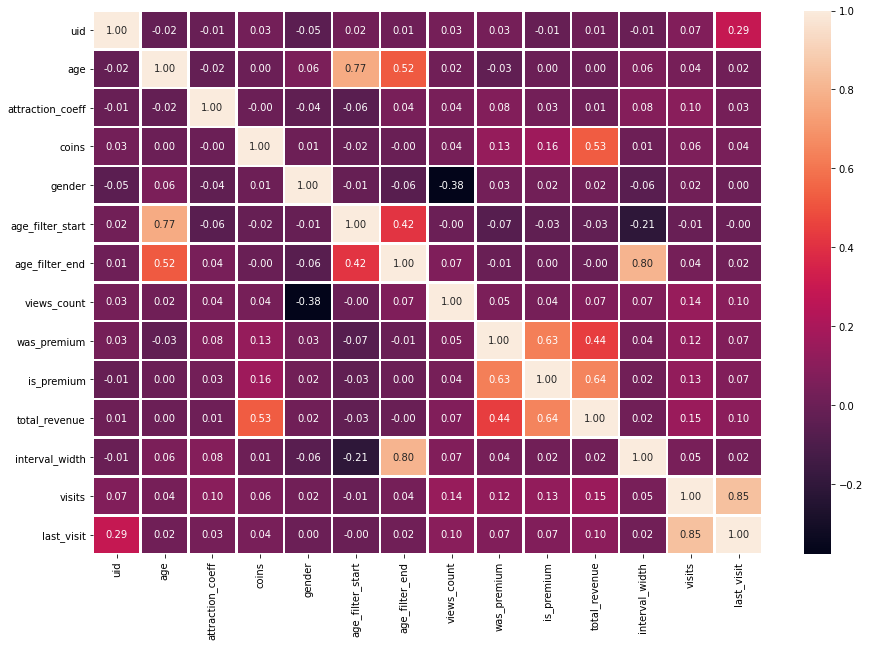

In [149]:
# удалив выбросы, рассмотрим корреляции между переменными, выраженные численно
corr = users.corr()

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=True, linewidths=1.5, fmt='.2f', ax=ax)
plt.show()

## Выводы

1) тестовая и контрольные группы однотипны, примерно одинаковы по размеру и количеству пропущенных значений,

2) распределения переменных в тестовой и контрольных группах качественно схожи, но для переменных coins и total_revenue могут отличаться количественно (точно мы этого не знаем, т.к. не проводили статистических тестов),

3) незначительное количество выбросов и сомнительных значений были удалены и в дальнейшем анализе не участвуют,

4) часть переменных между собой коррелируют, и это логически объяснимо: age и age_filter_start, uid и last_visit (last_visit - это день последнего визита с момента регистрации, он взаимосвязан с датой регистрации, так как новые пользователи провели в приложении не больше дней, чем длительность эксперимента, а uid назначается в порядке регистрации пользователей), gender и views_count (мужские аккаунты/профили получают меньше внимания), age_filter_start и age_filter_end (эти переменные связаны с возрастом самого пользователя), was_premium и is_premium, is_premium и visits (если пользователь купил премиум, то продукт ему интересен, и он будет чаще его использовать), visits и last_visit,

5) total_revenue коррелирует с переменными is_premium, coins, visits,

6) покупатели продуктов premium_trial и premium_no_trial наиболее "перспективны" для анализа: есть основания полагать, что в тестовой группе в среднем чаще покупают премиум.

## Проверим, имеет ли смысл добавлять новый способ оплаты для всех пользователей

Был проведен эксперимент, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. 

### Гипотеза: 
такое нововведение увеличит выручку компании. 

### Основная метрика: 
средняя выручка на одного пользователя. Так как нововведение никак не может повлиять на количество новых пользователей, общая выручка компании напрямую зависит от средней выручки на одного пользователя. Метрика вычисляется как отношение суммарной выручки total_revenue по всем пользователям к количеству пользователей.

### "Вторичные" метрики (были рассмотрены в ходе предварительного анализа): 
конверсия (отношение количества платящих пользователей к общему количеству пользователей), 

ARPPU (отношение суммарной выручки к количеству пользователей, которые платят сервису).

Проверим, изменилась ли средняя выручка в тестовой группе, так как эта метрика наилучшим образом отражает цель нашего бизнеса (прибыль). 

Для выявления отличий между группами пользователей будем, в основном, использовать критерий Стьюдента, при множественных сравнениях возможно применение поправки Тьюки. Это классический критерий для проверки гипотезы о равенстве средних значений генеральных совокупностей при независимых выборках (наш случай, ведь мы тестируем среднюю выручку, и поведение пользователя независимо от других пользователей). Альтернативы существуют (например, критерий Манна-Уитни, бутстрап) и имеют свои достоинства и недостатки. Так, критерий Манна-Уитни менее чувствителен к выбросам и отклонениям от нормального распределения, но зато "не любит" повторяющихся значений (а в нашей выборке много нулевых значений), бутстрап позволяет отдельно оценить разницу по квантилям, но он требователен к вычислительным мощностям. Наша выборка распределена не нормально, но применение критерия Стьюдента в этом случае допускается при однородности дисперсий, а выбросы уже удалены.

Проверим равенство дисперсий тестовой и двух контрольных групп по отдельности, а также тестовой группы и объединения двух контрольных групп по критерию Левена с уровнем значимости 0.05, в качестве метрики среднего значения - медиана (рекомендуется для не нормально распределенных данных). Стоит ли доверять этому критерию при условии не нормально распределенных данных - в разных источниках информация разнится.

In [150]:
# среднее квадратическое отклонение по группам (показатель, характеризующий дисперсию, но при этом 
# имеющий более интуитивно понятный масштаб)
users.groupby('group').agg({'total_revenue': 'std'}).rename(columns={'total_revenue': 'std'})

,std
group,
control1,3072.677600
control2,2859.935308
test,3352.688350


На первый взгляд, у тестовой группы стандартное отклонение (а значит, и дисперсия) отличается от контрольных групп. А что говорит статистический критерий (Левена)? 

Если результирующее p-значение критерия Левена меньше некоторого уровня значимости (в данном случае 0.05), полученные различия в отклонениях выборки вряд ли имели место на основе случайной выборки из совокупности с равными отклонениями. 

In [151]:
# подготовим выборки для сравнения
united_control_sample = users[users.group != 'test'].total_revenue
control1_sample = users[users.group == 'control1'].total_revenue
test_sample = users[users.group == 'test'].total_revenue
control2_sample = users[users.group == 'control2'].total_revenue
# массив пар для сравнения
samples = [['test и control1', test_sample, control1_sample], 
           ['test и control2', test_sample, control2_sample], 
           ['control1 и control2', test_sample, control1_sample], 
           ['test и united_control', test_sample, united_control_sample]]

# попарное сравнение дисперсий по критерию Левена
for samples_to_compare in samples:
    (s, p) = levene(samples_to_compare[1], samples_to_compare[2])
    if p > 0.05: 
        result = "H0 не отвергается (нет разницы)"
    else:
        result = "H0 отвергается (есть разница)"
    print("Сравниваем дисперсию ", samples_to_compare[0], ": pvalue = ", round(p, 3), ". ", result)

Сравниваем дисперсию  test и control1 : pvalue =  0.807 .  H0 не отвергается (нет разницы)
Сравниваем дисперсию  test и control2 : pvalue =  0.807 .  H0 не отвергается (нет разницы)
Сравниваем дисперсию  control1 и control2 : pvalue =  0.807 .  H0 не отвергается (нет разницы)
Сравниваем дисперсию  test и united_control : pvalue =  0.995 .  H0 не отвергается (нет разницы)


Таким образом, нулевая гипотеза о равных дисперсиях отвергается, и делается вывод о том, что существует разница между дисперсиями в генеральной совокупности. Все проведенные сравнения не отвергают гипотезу о равенстве дисперсий соответствующих групп.

Имеет смысл проверить, насколько качественно были отобраны тестовая и контрольные выборки, то есть, отличаются ли друг от друга контрольные выборки по средней выручке. На самом деле, и по остальным переменным тоже, но отличие по остальным переменным было оценено визуально как достаточно небольшое, за исключением переменной coins, которая в данном анализе не очень интересна.

То есть, необходимо сравнение средних значений выручки в группах control1 и control2.

Также необходимо сравнить тестовую и контрольную группу. Если две тестовые группы статистически не отличаются, то не имеет значения, с какой из контрольных групп (или с их объединением) сравнивать тестовую. Проведем сравнение трех групп пользователей между собой, при проведении теста можно сделать поправку на множественные сравнения (критерий Тьюки).

Проверим гипотезу Н0: средние во всех трех группах совпадают.
Зададим уровень значимости 0.05.

In [152]:
print(pairwise_tukeyhsd(users.total_revenue, users.group))

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj    lower    upper   reject
-----------------------------------------------------------
control1 control2 -33.3275 0.8725 -190.3699 123.7148  False
control1     test -16.8813 0.9654 -173.5544 139.7918  False
control2     test  16.4462 0.9674 -140.8771 173.7695  False
-----------------------------------------------------------


Результаты сравнения говорят о том, что: 

1) группы для сравнения отобраны корректно (контрольные группы не отличаются) и 

2) АВ-тест показывает, что для групп test и control1, test и control2 пользователей среднее значение выручки статистически значимо не отличается.

В дальнейшем будем использовать для сравнений тестовой и контрольной групп 1ю контрольную группу, так как лишние сравнения увеличивают вероятность ошибки 2го рода. Это решение эквивалентно использованию 2й контрольной группы или объединенной из двух контрольных групп.

### Вывод: нововведение в целом не прижилось. Средняя выручка на пользователия статистически значимо не изменилась, зато снизилась конверсия (в тестовой группе по сравнению с контрольными).

## Имеет ли смысл нововведение для определенных групп пользователей?

Проверим, имеет ли смысл вообще искать отдельные группы пользователей, или распределения выручки одинаковы в обеих группах.

### Бутстрапом проверим каждый дециль распределения выручки, исключив неплатящих пользователей

In [153]:
def get_percentile_ci(bootstrap_stats, pe, alpha):
    # Строит перцентильный доверительный интервал
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right


B = 2000
alpha = 0.05

values_a = users[(users.group == 'control1') & (users.total_revenue > 0)].total_revenue
values_b = users[(users.group == 'test') & (users.total_revenue > 0)].total_revenue

quantiles = [i * 0.1 for i in range(1, 10)]

for q in quantiles:
    pe = np.quantile(values_b, q) - np.quantile(values_a, q)
    bootstrap_values_a = np.random.choice(values_a, (B, values_a.size), True)
    bootstrap_metrics_a = np.quantile(bootstrap_values_a, q, axis=1)
    bootstrap_values_b = np.random.choice(values_b, (B, values_b.size), True)
    bootstrap_metrics_b = np.quantile(bootstrap_values_b, q, axis=1)
    bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a
    ci = get_percentile_ci(bootstrap_stats, pe, alpha)
    has_effect = not (ci[0] < 0 < ci[1])

    print(f'Значение {int(q * 100)}% квантиля изменилось на: {pe:0.2f}')
    print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
    print(f'Отличия статистически значимые: {has_effect}')
    print()

Значение 10% квантиля изменилось на: 195.00
95.0% доверительный интервал: (-1651.00, 1749.93)
Отличия статистически значимые: False

Значение 20% квантиля изменилось на: 1570.40
95.0% доверительный интервал: (-663.26, 4043.39)
Отличия статистически значимые: False

Значение 30% квантиля изменилось на: 2802.80
95.0% доверительный интервал: (1321.71, 4396.79)
Отличия статистически значимые: True

Значение 40% квантиля изменилось на: 3684.20
95.0% доверительный интервал: (306.80, 6201.00)
Отличия статистически значимые: True

Значение 50% квантиля изменилось на: 3237.00
95.0% доверительный интервал: (2327.00, 3640.00)
Отличия статистически значимые: True

Значение 60% квантиля изменилось на: 2264.60
95.0% доверительный интервал: (169.00, 3364.66)
Отличия статистически значимые: True

Значение 70% квантиля изменилось на: 1367.60
95.0% доверительный интервал: (111.80, 4004.00)
Отличия статистически значимые: True

Значение 80% квантиля изменилось на: 3234.40
95.0% доверительный интервал: (1

Вывод: не во всех сегментах значение выручки не изменилось. Можно поискать группы пользователей, для которых есть различия.

Например:

1) по странам. У этих групп пользователей отличаются как благосостояние, так и образ жизни, и отношение к знакомствам,

2) по привлекательности. Возможно, уровень привлекательности влияет на отношение к онлайн знакомствам. Высокий/низкий уровень привлекательности может привести к желанию использовать больше возможностей приложения,

3) частота пользования приложением. Высокая частота может означать большую заинтересованность (частота рассчитывается как количество визитов, так как если принять за единицу времени длительность эксперимента*, то количество визитов в единицу времени и будет частотой),

* Длительность эксперимента в явном виде в датасете не приведена, но я при исследовании полагаю, что все приведенные данные относятся ко времени эксперимента, и что в датасете присутствуют все данные, относящиеся к эксперименту.

### 1) По странам. Для большинства стран (не вошли страны, из которых пришло мало пользователей: менее 0.5%) проверяется гипотеза Н0  о том, что средняя выручка у пользователей из этой страны не различается для тестовой и 1-й контрольной групп. Уровень значимости 0.05.

In [154]:
# Для каждой из стран проверяем гипотезу Н0 о равенстве средних значений выручки
for countryname in set(users.top_country.values):
    p = stats.ttest_ind(users[(users.group == 'test') & (users.top_country == countryname)].total_revenue, 
        users[(users.group == 'control1') & (users.top_country == countryname)].total_revenue)[1]
    s = users[(users.group == 'test') & (users.top_country == countryname)].total_revenue.mean() - \
        users[(users.group == 'control1') & (users.top_country == countryname)].total_revenue.mean()
    if p >= 0.05:
        result = 'различий нет'
    else:
        result = 'различия есть'
    print(countryname, ': разница средних (тест-контроль)=', round(s, 2), ', p-value=', round(p, 3), ', ', result)

United Arab Emirates : разница средних (тест-контроль)= 32.48 , p-value= 0.883 ,  различий нет
Chile : разница средних (тест-контроль)= -82.82 , p-value= 0.662 ,  различий нет
Argentina : разница средних (тест-контроль)= 102.84 , p-value= 0.712 ,  различий нет
Italy : разница средних (тест-контроль)= -92.36 , p-value= 0.65 ,  различий нет
Other : разница средних (тест-контроль)= -1212.94 , p-value= 0.218 ,  различий нет
United Kingdom (Great Britain) : разница средних (тест-контроль)= -863.76 , p-value= 0.156 ,  различий нет
France : разница средних (тест-контроль)= 79.83 , p-value= 0.714 ,  различий нет
United States of America : разница средних (тест-контроль)= 12.34 , p-value= 0.923 ,  различий нет
Portugal : разница средних (тест-контроль)= -194.35 , p-value= 0.217 ,  различий нет
Canada : разница средних (тест-контроль)= -220.3 , p-value= 0.543 ,  различий нет
Australia : разница средних (тест-контроль)= -162.9 , p-value= 0.629 ,  различий нет
Germany : разница средних (тест-контр

Во всех странах не обнаружено значимых различий между тестовой и контрольной группами.

Однако в различных странах могут отличаться паттерны поведения (а значит, и ценности) у различных половозрастных групп. Проверим гипотезу Н0 на группах мужчин разных возрастов в разных странах (проверяем именно мужчин, так как мужчины традиционно проявляют больше заинтересованности в услугах дейтингового приложения, что видно и по имеющемуся датасету).

In [155]:
# Для каждой из стран проверяем гипотезу Н0 о равенстве средних значений выручки, но только для пожилых мужчин
for countryname in set(users.top_country.values):
    sample1 = users[(users.group == 'test') & (users.top_country == countryname) & (users.gender == 1) & 
             (users.age >= 50)].total_revenue
    sample2 = users[(users.group == 'control1') & (users.top_country == countryname) & (users.gender == 1) & 
             (users.age >= 50)].total_revenue
    s = sample1.mean() - sample2.mean()
    if (sample1.size < 30) | (sample2.size < 30):
        p = np.nan
    else:
        p = stats.ttest_ind(sample1, sample2)[1]
    if pd.isna(p):
        result = 'мало наблюдений'
    elif p >= 0.05:
        result = 'различий нет'
    else:
        result = 'различия есть'
    print(countryname, ': разница средних (тест-контроль)=', round(s, 2), ', p-value=', round(p, 3), ', ', result)

United Arab Emirates : разница средних (тест-контроль)= nan , p-value= nan ,  мало наблюдений
Chile : разница средних (тест-контроль)= 0.0 , p-value= nan ,  мало наблюдений
Argentina : разница средних (тест-контроль)= 0.0 , p-value= nan ,  мало наблюдений
Italy : разница средних (тест-контроль)= 368.83 , p-value= nan ,  мало наблюдений
Other : разница средних (тест-контроль)= nan , p-value= nan ,  мало наблюдений
United Kingdom (Great Britain) : разница средних (тест-контроль)= 0.0 , p-value= nan ,  мало наблюдений
France : разница средних (тест-контроль)= 0.0 , p-value= nan ,  мало наблюдений
United States of America : разница средних (тест-контроль)= -340.68 , p-value= 0.407 ,  различий нет
Portugal : разница средних (тест-контроль)= 0.0 , p-value= nan ,  мало наблюдений
Canada : разница средних (тест-контроль)= 805.83 , p-value= nan ,  мало наблюдений
Australia : разница средних (тест-контроль)= -4467.67 , p-value= nan ,  мало наблюдений
Germany : разница средних (тест-контроль)= 51

In [156]:
# Для каждой из стран проверяем гипотезу Н0 о равенстве средних значений выручки, но только для мужчин средних лет
for countryname in set(users.top_country.values):
    sample1 = users[(users.group == 'test') & (users.top_country == countryname) & (users.gender == 1) & 
              (users.age >= 30) & (users.age < 50)].total_revenue
    sample2 = users[(users.group == 'control1') & (users.top_country == countryname) & (users.gender == 1) & 
              (users.age >= 30) & (users.age < 50)].total_revenue
    s = sample1.mean() - sample2.mean()
    if (sample1.size < 30) | (sample2.size < 30):
        p = np.nan
    else:
        p = stats.ttest_ind(sample1, sample2)[1]
    if pd.isna(p):
        result = 'мало наблюдений'
    elif p >= 0.05:
        result = 'различий нет'
    else:
        result = 'различия есть'
    print(countryname, ': разница средних (тест-контроль)=', round(s, 2), ', p-value=', round(p, 3), ', ', result)

United Arab Emirates : разница средних (тест-контроль)= 315.43 , p-value= 0.317 ,  различий нет
Chile : разница средних (тест-контроль)= -3.12 , p-value= 0.991 ,  различий нет
Argentina : разница средних (тест-контроль)= 728.22 , p-value= 0.19 ,  различий нет
Italy : разница средних (тест-контроль)= -274.86 , p-value= 0.298 ,  различий нет
Other : разница средних (тест-контроль)= 111.05 , p-value= nan ,  мало наблюдений
United Kingdom (Great Britain) : разница средних (тест-контроль)= -979.92 , p-value= 0.351 ,  различий нет
France : разница средних (тест-контроль)= 65.4 , p-value= 0.821 ,  различий нет
United States of America : разница средних (тест-контроль)= 380.24 , p-value= 0.031 ,  различия есть
Portugal : разница средних (тест-контроль)= -103.28 , p-value= 0.348 ,  различий нет
Canada : разница средних (тест-контроль)= -354.72 , p-value= 0.569 ,  различий нет
Australia : разница средних (тест-контроль)= -199.33 , p-value= nan ,  мало наблюдений
Germany : разница средних (тест-к

In [157]:
# обнаружена одна группа пользователей со значимым повышением выручки на одного пользователя. А что с конверсией?
conv_USA_male_mid = \
    users[(users.total_revenue > 0) & (users.age >= 30) & (users.age < 50) & (users.gender == 1) & 
          (users.country == 'United States of America')].groupby('group').agg({'uid': 'count'}) / \
    users[(users.age >= 30) & (users.age < 50) & (users.gender == 1) & 
          (users.country == 'United States of America')].groupby('group').agg({'uid': 'count'})

print('Повышение конверсии в указанной группе в', 
      round(conv_USA_male_mid.uid['test'] / conv_USA_male_mid.uid['control1'], 1), 
      ' раза в тестовой группе по отношению к контрольной')
conv_USA_male_mid

Повышение конверсии в указанной группе в 1.9  раза в тестовой группе по отношению к контрольной


,uid
group,
control1,0.030142
control2,0.038321
test,0.057252


In [158]:
revenue_USA_male_mid = \
    users[(users.age >= 30) & (users.age < 50) & (users.gender == 1) & 
          (users.country == 'United States of America')].groupby('group').agg({'total_revenue': 'mean'})

print('Повышение ARPU в', 
      round(revenue_USA_male_mid.total_revenue['test'] / revenue_USA_male_mid.total_revenue['control1'], 2), 'раза')
revenue_USA_male_mid

Повышение ARPU в 2.08 раза


,total_revenue
group,
control1,351.829787
control2,387.888686
test,732.068702


In [159]:
# Для каждой из стран проверяем гипотезу Н0 о равенстве средних значений выручки, но только для молодых мужчин
for countryname in set(users.top_country.values):
    sample1 = users[(users.group == 'test') & (users.top_country == countryname) & (users.gender == 1) & 
             (users.age < 30)].total_revenue
    sample2 = users[(users.group == 'control1') & (users.top_country == countryname) & (users.gender == 1) & 
             (users.age < 30)].total_revenue
    s = sample1.mean() - sample2.mean()
    if (sample1.size < 30) | (sample2.size < 30):
        p = np.nan
    else:
        p = stats.ttest_ind(sample1, sample2)[1]
    if pd.isna(p):
        result = 'мало наблюдений'
    elif p >= 0.05:
        result = 'различий нет'
    else:
        result = 'различия есть'
    print(countryname, ': avg(test)-avg(control)=', round(s, 2), ', p-value=', round(p, 3), ', ', result)

United Arab Emirates : avg(test)-avg(control)= -55.5 , p-value= 0.856 ,  различий нет
Chile : avg(test)-avg(control)= -150.64 , p-value= 0.606 ,  различий нет
Argentina : avg(test)-avg(control)= -472.5 , p-value= 0.019 ,  различия есть
Italy : avg(test)-avg(control)= -1.22 , p-value= 0.997 ,  различий нет
Other : avg(test)-avg(control)= -2204.07 , p-value= 0.259 ,  различий нет
United Kingdom (Great Britain) : avg(test)-avg(control)= -675.01 , p-value= 0.416 ,  различий нет
France : avg(test)-avg(control)= 137.74 , p-value= 0.723 ,  различий нет
United States of America : avg(test)-avg(control)= -221.5 , p-value= 0.303 ,  различий нет
Portugal : avg(test)-avg(control)= -329.95 , p-value= 0.326 ,  различий нет
Canada : avg(test)-avg(control)= -350.02 , p-value= 0.246 ,  различий нет
Australia : avg(test)-avg(control)= 373.01 , p-value= nan ,  мало наблюдений
Germany : avg(test)-avg(control)= 576.78 , p-value= 0.33 ,  различий нет
Switzerland : avg(test)-avg(control)= 124.88 , p-value= n

In [160]:
revenue_Argentina_male_young = \
    users[(users.age < 30) & (users.gender == 1) & (users.country == 'Argentina')].\
    groupby('group').agg({'total_revenue': 'mean'})

print('Повышение ARPU в', 
      revenue_Argentina_male_young.total_revenue['test'] / 
      revenue_Argentina_male_young.total_revenue['control1'], 'раза')
revenue_Argentina_male_young

Повышение ARPU в 0.0 раза


,total_revenue
group,
control1,472.500000
control2,346.690608
test,0.000000


Обнаружены две группы пользователей, для которых выручка с пользователя значимо отличается в тестовой группе по сравнению с контрольной:

1) для мужчин среднего возраста из США выручка выросла;

2) для молодых мужчин из Аргентины выручка снизилась до нулевого значения. Это может быть ошибкой первого рода и на самом деле нет значимых различий между контрольной и тестовой группами. В любом случае, есть снижение выручки или нет значимых различий - нововведение этой группе пользователей предлагать не надо. 

Проверка конверсии особенно важна в первом случае, так как мы при проведении теста не делали поправку на множественное тестирование.

### 2) переменная attraction_coeff. Проверяется гипотеза Н0 о том, что средняя выручка не отличается для тестовой и 1-й контрольной групп у пользователей соответствующей группы по привлекательности. Уровень значимости 0.05

In [161]:
users.attraction_coeff.quantile([0.25, 0.5, 0.75])

0.25      0.0
0.50    250.0
0.75    529.0
Name: attraction_coeff, dtype: float64

In [162]:
# группы для сравнения
attraction_sets = [['0 attraction', 
     users[(users.attraction_coeff == 0) & (users.group == 'test')], 
     users[(users.attraction_coeff == 0) & (users.group == 'control1')]], 
    ['1 quartile attraction', 
     users[(users.attraction_coeff > 0) & (users.attraction_coeff < 250) & (users.group == 'test')], 
     users[(users.attraction_coeff > 0) & (users.attraction_coeff < 250) & (users.group == 'control1')]], 
    ['2 quartile attraction', 
     users[(users.attraction_coeff >= 250) & (users.attraction_coeff < 529) & (users.group == 'test')], 
     users[(users.attraction_coeff >= 250) & (users.attraction_coeff < 529) & (users.group == 'control1')]], 
    ['3 quartile attraction', 
     users[(users.attraction_coeff >= 529) & (users.group == 'test')], 
     users[(users.attraction_coeff >= 529) & (users.group == 'control1')]]]

# сравнение
for attraction in attraction_sets:
    p = stats.ttest_ind(attraction[1].total_revenue, attraction[2].total_revenue)[1]
    conv_test = attraction[1][attraction[1].total_revenue > 0].shape[0] / attraction[1].shape[0]
    conv_control = attraction[2][attraction[2].total_revenue > 0].shape[0] / attraction[2].shape[0]
    if p >= 0.05:
        result = 'различий нет'
    else:
        result = 'различия есть'
    print(attraction[0], ', p-value=', round(p, 3), ', ', result, ', conversion_difference =', 
          round(conv_test - conv_control, 4))

0 attraction , p-value= 0.181 ,  различий нет , conversion_difference = -0.0092
1 quartile attraction , p-value= 0.78 ,  различий нет , conversion_difference = -0.0114
2 quartile attraction , p-value= 0.668 ,  различий нет , conversion_difference = -0.0238
3 quartile attraction , p-value= 0.657 ,  различий нет , conversion_difference = 0.0023


Вывод: в группах по уровню привлекательности средняя выручка не изменилась, а конверсия снизилась*. Значит, не стоит распространять нововведение среди пользователей, сгруппированных по этому признаку.

* Утверждение о том, что конверсия снизилась, не выглядит здесь достаточно обоснованным, т.к. это снижение может быть статистически незначимо. Тем не менее, проверять его излишне: это имело бы смысл, если бы конверсия выросла, а предполагать это нет никаких оснований.

### 3) переменная visits. Проверяется гипотеза Н0 о том, что средняя выручка не отличается для тестовой и 1-й контрольной групп у пользователей соответствующей группы по частоте посещения приложения. Уровень значимости 0.05

In [163]:
users.visits.quantile([0.25, 0.5, 0.75])

0.25    0.0
0.50    2.0
0.75    7.0
Name: visits, dtype: float64

In [164]:
# группы для сравнения
visits_sets = [['0 visits', 
                users[(users.visits == 0) & (users.group == 'test')], 
                users[(users.visits == 0) & (users.group == 'control1')]], 
               ['1 quartile visits', 
                users[(users.visits > 0) & (users.visits <= 2) & (users.group == 'test')], 
                users[(users.visits > 0) & (users.visits <= 2) & (users.group == 'control1')]], 
               ['2 quartile visits', 
                users[(users.visits > 2) & (users.visits <= 7) & (users.group == 'test')], 
                users[(users.visits > 2) & (users.visits <= 7) & (users.group == 'control1')]], 
               ['3 quartile visits', 
                users[(users.visits > 7) & (users.group == 'test')], 
                users[(users.visits > 7) & (users.group == 'control1')]]]

# сравнение
for visits in visits_sets:
    conv_test = visits[1][visits[1].total_revenue > 0].shape[0] / visits[1].shape[0]
    conv_control = visits[2][visits[2].total_revenue > 0].shape[0] / visits[2].shape[0]
    p = stats.ttest_ind(visits[1].total_revenue, visits[2].total_revenue)[1]
    if p >= 0.05:
        result = 'различий нет'
    else:
        result = 'различия есть'
    print(visits[0], ', p-value=', round(p, 3), ', ', result, ', conversion difference=', 
          round(conv_test - conv_control, 4))

0 visits , p-value= 0.256 ,  различий нет , conversion difference= 0.0014
1 quartile visits , p-value= 0.382 ,  различий нет , conversion difference= -0.0074
2 quartile visits , p-value= 0.625 ,  различий нет , conversion difference= -0.0163
3 quartile visits , p-value= 0.987 ,  различий нет , conversion difference= -0.0241


Вывод: в группах по количеству визитов средняя выручка не изменилась, а конверсия снизилась или осталась на том же уровне*. Значит, не стоит распространять нововведение среди пользователей, сгруппированных по этому признаку.

* Утверждение о том, что конверсия снизилась, не выглядит здесь достаточно обоснованным, т.к. это снижение может быть статистически незначимо. На мой взгляд, это тот случай, когда соотношение величин *можно* определять "визуально".

## Выводы

Проведен эксперимент с использованием новой платежной системы. Новый метод оплаты предлагался новым пользователям из нескольких стран, покупающим премиум-подписку. Цель нововведения - увеличение выручки (возможно, нововведение сделает более привлекательной мысль о покупке подписки). 

Данные зашумлены (лучше было бы не включать в анализ пользователей из стран, в которых новые платежные системы не предлагались), но, тем не менее, подобраны корректно: выбросов немного, распределения величин в целом схожие, контрольные группы не отличаются, в данных есть логика, соответствующая предметной области. Однако для наиболее качественного анализа в датасете не хватает информации о платежных системах, через которые проходил каждый платеж.

Установлено, что в результате распространения нововведения на всех пользователей прибыль не должна увеличиться: хотя средняя выручка с платящего пользователя и возросла на 17% в тестовой группе, но конверсия снизилась на 1 процентный пункт (до 40 % по сравнению с группой пользователей, которым нововведение не предлагалось), в результате чего средняя выручка с пользователя (рассчитанная по всем пользователям) статистически значимо не изменилась. А для успеха эксперимента необходимо, чтобы средняя выручка статистически значимо возросла; желательно - настолько, чтобы цена внедрения новых платежных систем была ниже дополнительно полученной прибыли. 

Удалось обнаружить отдельную группу пользователей, которых нововведение заинтересовало: это мужчины средних лет из США: для них средняя выручка выросла вдвое, конверсия на 90%. Это может означать, помимо всего прочего, что внедренные платежные системы наиболее актуальны и удобны именно для США - стоит проанализировать, какие новые платежные системы могли бы дать тот же эффект в других странах.